In [1]:
import numpy as np
import matplotlib.pyplot as plt

from evaluation import eval_multi, MODE_ADVERSARY, MODE_RANDOM
%load_ext autoreload
%autoreload 2

In [2]:
d = 5
n_gen_context = 20 # Sample from the action set
alpha_set = [1.0] # Bonus for UCB
v_set = [1.0] # Bonus for TS
alpha_PHE_set = [1.0] # Bonus for PHE
T = 1000 # Timesteps
n_sim = 3 # Number of Simulations
m = 3
n_task = 5
assert m<=d, "m >= d"
assert T>=d**2, "T < d**2"
is_multi = True
adv_const = 1 # scaling factor for adversary task generation
input_dict = {
    "d":d,
    "n_gen_context":n_gen_context,
    "T":T,
    "n_sim":n_sim,
    "rho":0.5,
    "noise_std":1,
    "seed":None,
    "output":True,
    "params_set":alpha_set,
    "m":m,
    "n_task":n_task,
    "adv_const":adv_const,
    "mode":MODE_ADVERSARY
}

In [4]:
input_dict["name"] = "UCB"
input_dict["params_set"] = alpha_set
if is_multi:
    best_UCB = eval_multi(input_dict)
else:
    best_UCB = eval(input_dict)

UCB Simulation 1, N_gen_ctx=20, d=5, alpha=1.000


100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


UCB Simulation 2, N_gen_ctx=20, d=5, alpha=1.000


100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


UCB Simulation 3, N_gen_ctx=20, d=5, alpha=1.000


100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


In [5]:
input_dict["name"] = "TS"
input_dict["params_set"] = v_set
if is_multi:
    best_TS = eval_multi(input_dict)
else:
    best_TS = eval(input_dict)

TS Simulation 1, N_gen_ctx=20, d=5, alpha=1.000


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


TS Simulation 2, N_gen_ctx=20, d=5, alpha=1.000


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


TS Simulation 3, N_gen_ctx=20, d=5, alpha=1.000


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


In [6]:
input_dict["name"] = "PHE"
input_dict["params_set"] = alpha_PHE_set
if is_multi:
    best_PHE = eval_multi(input_dict)
else:
    best_PHE = eval(input_dict)

PHE Simulation 1, N_gen_ctx=20, d=5, alpha=1.000


100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


PHE Simulation 2, N_gen_ctx=20, d=5, alpha=1.000


100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


PHE Simulation 3, N_gen_ctx=20, d=5, alpha=1.000


100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


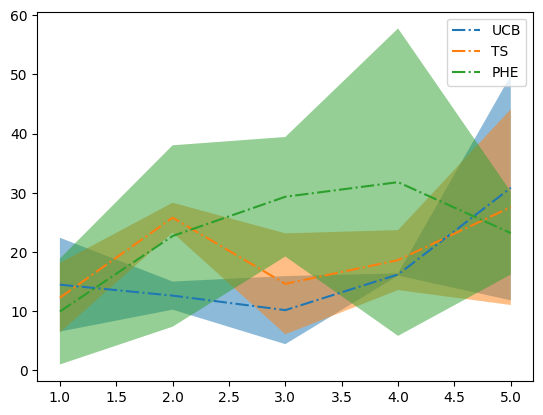

In [7]:
if is_multi:
    mean_UCB = best_UCB['regrets']
    std_UCB = np.std(mean_UCB, axis=0)
    mean_UCB = np.mean(mean_UCB, axis=0)
    mean_TS = best_TS['regrets']
    std_TS = np.std(mean_TS, axis=0)
    mean_TS = np.mean(mean_TS, axis=0)
    mean_PHE = best_PHE['regrets']
    std_PHE = np.std(mean_PHE, axis=0)
    mean_PHE = np.mean(mean_PHE, axis=0)

    plt.plot(np.arange(1,n_task+1), mean_UCB, '-.', label='UCB')
    plt.fill_between(np.arange(1,n_task+1), mean_UCB-std_UCB, mean_UCB+std_UCB, alpha=0.5)
    plt.plot(np.arange(1,n_task+1), mean_TS, '-.', label='TS')
    plt.fill_between(np.arange(1,n_task+1), mean_TS-std_TS, mean_TS+std_TS, alpha=0.5)
    plt.plot(np.arange(1,n_task+1), mean_PHE, '-.', label='PHE')
    plt.fill_between(np.arange(1,n_task+1), mean_PHE-std_PHE, mean_PHE+std_PHE, alpha=0.5)
else:
    mean_UCB = np.mean(best_UCB['regrets'], axis=0)
    std_UCB = np.std(best_UCB['regrets'], axis=0)
    mean_TS = np.mean(best_TS['regrets'], axis=0)
    std_TS = np.std(best_TS['regrets'], axis=0)
    mean_PHE = np.mean(best_PHE['regrets'], axis=0)
    std_PHE = np.std(best_PHE['regrets'], axis=0)

    plt.plot(np.arange(1,T+1), mean_UCB, '-.', label='UCB')
    plt.fill_between(np.arange(1,T+1), mean_UCB-std_UCB, mean_UCB+std_UCB, alpha=0.5)
    plt.plot(np.arange(1,T+1), mean_TS, '-.', label='TS')
    plt.fill_between(np.arange(1,T+1), mean_TS-std_TS, mean_TS+std_TS, alpha=0.5)
    plt.plot(np.arange(1,T+1), mean_PHE, '-.', label='PHE')
    plt.fill_between(np.arange(1,T+1), mean_PHE-std_PHE, mean_PHE+std_PHE, alpha=0.5)

plt.legend()
plt.show()
plt.close()